<a href="https://colab.research.google.com/github/Pradeep2535/SpreadSheet-Automation/blob/main/LangGraph_Automation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --quiet langchain langchain-community langgraph langchain-google-genai langchain_experimental

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.7/144.7 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.2/209.2 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 10.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the sou

In [ ]:
!pip install google-ai-generativelanguage==0.6.15

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.6 MB/s eta 0:00:00
  Attempting uninstall: google-ai-generativelanguage
    Found existing installation: google-ai-generativelanguage 0.6.17
    Uninstalling google-ai-generativelanguage-0.6.17:
      Successfully uninstalled google-ai-generativelanguage-0.6.17
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-google-genai 2.1.2 requires google-ai-generativelanguage<0.7.0,>=0.6.16, but you have google-ai-generativelanguage 0.6.15 which is incompatible.


In [ ]:
from typing import Annotated
from typing import Literal
from langchain_core.tools import tool
from typing_extensions import TypedDict
from langgraph.graph import MessagesState, END,StateGraph, START,MessagesState
from langgraph.types import Command
from langchain_core.messages import HumanMessage,AIMessage
from langgraph.prebuilt import create_react_agent
from langchain_experimental.utilities import PythonREPL
from IPython.display import display,Image
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode, tools_condition

In [ ]:
from google.colab import userdata
import os

os.environ['GOOGLE_API_KEY'] = userdata.get('GOOGLE_API_KEY_1')

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")
llm.invoke("hi")

AIMessage(content='Hi there! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run-d54c1003-5587-4ffd-9c3f-0561aa2c627b-0', usage_metadata={'input_tokens': 1, 'output_tokens': 11, 'total_tokens': 12, 'input_token_details': {'cache_read': 0}})

In [ ]:
import gspread

gc = gspread.service_account(filename="/content/credentials.json")
sheet = gc.open("Project_Management").worksheet("Sheet2")


In [ ]:
sheet.get_all_values()

[['Name', 'Age', 'City']]

In [ ]:
researcher_prompt = """Role:
You are a helpful AI assistant collaborating with other assistants to process tasks in a spreadsheet.

Responsibilities:

Your job is to determine the necessary operations that should be performed on the spreadsheet to achieve the given goal.

Do not generate Python code. Your task is only to analyze the spreadsheet data and decide what changes need to be made.

If modifications are required, pass the relevant data to other assistants that handle execution.

If no modifications are needed, indicate when the operation is complete so the workflow stops.

Spreadsheet Data Format
The current data in the spreadsheet is provided as a dictionary, where:

Keys represent column names.

Values represent corresponding row values.

Example of Spreadsheet Data:
python
Copy
Edit
{
    "Team Name": "Tholas",
    "Team Members": "Pradeep, Rajesh",
    "Task": "Module Development",
    "Status": "Completed",
    "Priority": "High"
},
{
    "Team Name": "DevStorm",
    "Team Members": "Vinoth, Pradeep",
    "Task": "API Integration",
    "Status": "Not Started",
    "Priority": "Medium"
}

Use this data to determine whether an operation needs to be performed or has already been completed.

Handling Operations
If the requested operation has already been performed and no modification is required:

Prefix your response with: "FINAL ANSWER"

This signals that the task is complete and no further action is needed.

If additional steps are required from other assistants:

Do not include "FINAL ANSWER" in your response.

Instead, ensure that the next assistant receives the necessary data to proceed.

If you are unsure, need confirmation, or require more details from the human user:

Use the ask_human_input() tool to request clarification.

If the tool call is made, then the Conversation between Human and Tool will be provided to you, so that you can get the clarified answer and the context and decide the operation to be performed.\n

Example: If the user message is "add", you must call the tool for more details before proceeding.
Tool call will be made, then the Conversation between Human and Tool will be provided to you, so that you can get the clarified answer and the context and decide the operation to be performed.

Strict Guidelines
Do NOT assume or create your own values when modifying the spreadsheet unless and otherwise asked by the user in input. But if the user asks to use ai or some random values as data, you should generate ai values for the asked data and pass those values to another assistant to perform the specified operation in the spreadsheet with the values.
eg: HumanMessage : use some random or ai generated name to populate names column\n
Action : generate ai names and pass those names to another assistant ans ask to add it in names column.

If you cannot proceed further or need to end the process, prefix your response with "FINAL ANSWER".

You should always instruct the other assistant with the opertion needed to performed with the values passed by the user.
"""


In [ ]:

def get_sheet_data_as_string(sheet):
    data = sheet.get_all_values()
    if not data:
        return "Sheet is empty."
    headers = data[0]
    rows = data[1:]

    formatted_rows = [dict(zip(headers, row)) for row in rows]
    if headers == [] and rows == []:
        return "Sheet is empty."
    response="\n".join(str(row) for row in formatted_rows)
    # print(headers)
    if response =="" and headers != []:
       return "Sheet is empty but headers are present in first row"+ "Headers: "+ ",".join(headers)
    return response


In [ ]:
get_sheet_data_as_string(sheet)

'Sheet is empty but headers are present in first rowHeaders: Name,Age,City'

In [ ]:
sheet.get_all_values()

[['Name', 'Age', 'City']]

In [ ]:

# def invoke_tool(state:AgentState):
#     tool_details= state['messages'][-1].additional_kwargs.get("tool_calls", [])[0]

#     if tool_details is None:
#         raise Exception("no tool call found")

#     print(f'Selected tool: {tool_details.get("function").get("name")}')

#     if tool_details.get("function").get("name")=="search":
#         response = input(prompt=f"[y/n] continue with expensive web search?")
#         if response == "n":
#             raise Exception("web search discard")

#     response = tool_mapping[tool_details['function']['name']].invoke(json.loads(tool_details.get("function").get("arguments")))
#     return {"messages" : [response]}

In [ ]:
# @tool
# def ask_human_input(state: MessagesState) -> str:
#     """
#     Use this tool when the user's question is vague, incomplete, or requires clarification to proceed.

#     This tool prompts the user for clarification or additional input.
#     """
#     print("Tool is called")
#     prompt = state["messages"][-1].content
#     response = input(prompt=f"[need clarification] {prompt}\n> ")
#     if response.lower() == "n":
#         raise Exception("User discarded clarification")
#     return response


In [ ]:
@tool
def ask_human_input(state: MessagesState) -> str:
    """
    Call this when the user's question is vague, incomplete, or needs clarification.
    This tool returns a message asking the user for clarification.
    """
    print("Tool is called")
    prompt = state["messages"][-1].content
    return f"Your question needs more clarification: '{prompt}'. Please provide more details."


In [ ]:
llm_with_tool = llm.bind_tools(tools=[ask_human_input])

In [ ]:
from langchain_core.messages import AIMessage, ToolMessage,SystemMessage

In [ ]:

def researcher(state: MessagesState) -> Command[Literal["code_generator", "tools", END]]:
    print("Researcher called")

    last_msg = state["messages"][-1]

    # print(last_user_msg,"Last msg")
    sheet_data_string = get_sheet_data_as_string(sheet)
    full_prompt = f"""{researcher_prompt}

                      User Task or Conversation between User and Tool:
                      {last_msg}

                      Current Sheet Data:
                      {sheet_data_string}
                      """

    result = llm_with_tool.invoke(full_prompt, tool_choice="auto")
    # print(result.tool_calls, "Tool Calls")

    if result.tool_calls:
        # print("Tool call detected:", result.tool_calls)
        tool_call = result.tool_calls[0]
        id = tool_call['id']
        return Command(
    update={
        "messages": [
            AIMessage(content=full_prompt),

              ToolMessage(content="".join(tool_call['args']['state']['messages']),tool_call_id=id),
        ],
        "tool_calls": [
            {
                "type": "function",
                "function": {
                    "name": tool_call["name"],
                    "arguments": tool_call["args"]["state"]["messages"],
                    "tool_call_id":id
                }
            }
        ]
    },
    goto="tools"
)


    msg = AIMessage(content=result.content, name="researcher")
    # print(msg.content + " -------------")

    if "FINAL ANSWER" in msg.content:
        # print(True, "FINAL ANSWER matched!")
        return Command(
            update={"messages": [msg]},
            goto=END
        )

    return Command(
        update={"messages": [msg]},
        goto="code_generator"
    )


In [ ]:
repl=PythonREPL()
repl.globals["gc"] = gc
repl.globals["sheet"] = sheet

In [ ]:
@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute the spreadsheet operation."],
):
    """Executes python code for spreadsheet operations using gspread."""

    try:
        # Use your pre-initialized REPL
        repl=PythonREPL()
        repl.globals["gc"] = gc
        repl.globals["sheet"] = sheet
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"

    return (
        f"Executed:\n{code}\nStdout: {result}"
    )


In [ ]:
def code_generator(state: MessagesState) -> Command[Literal["python_executor"]]:
    print("Generator called")
    last_msg = state["messages"][-1].content
    # print(last_msg)

    code_prompt = """You are a Python code generator and receive command from researcher assistant.
    Use the gspread API to modify a Google Sheet.
    Remember to place the cursor in the spreadsheet at correct position before reading or modifying the sheet to position the cursor correctly.
    You should not modify spreadsheet with any dummy data unless it is specified and only what instructed data should be modified.
    If you find anyother values in the cell where the operation needs someother value, then you have the permission to delete the old values and insert the required given values.
    - Use existing `sheet` object (already authenticated) and it is availaible in environment.
    - DO NOT use pandas.
    - Use: sheet.get_all_values(), sheet.update_cell(), sheet.append_row(), etc.
    - Print output to confirm what was done.(in stout - mandatory)
    - Output only Python code.
    - You can also use the current data in spreadsheet to make suitable operation.



    Instruction:\n""" + last_msg
    sheet_data_string = get_sheet_data_as_string(sheet)
    full_prompt = f"""{code_prompt}



                          Current Sheet Data:
                          {sheet_data_string}
                          """

    result = llm.invoke(full_prompt)
    # print(result.content.strip())
    msg = AIMessage(content=result.content.strip(), name="code_generator")

    return Command(update={"messages": [msg]}, goto="python_executor")


In [ ]:

def python_executor(state: MessagesState) -> Command[Literal["researcher",END]]:
    print("Executor called")
    code = state["messages"][-1].content
    output = python_repl_tool(code)
    msg = AIMessage(content=output, name="python_executor")
    # print("check" ,msg)
    return Command(
        update={"messages": [msg]},
        goto=END if "FINAL ANSWER" in output else "researcher"
    )


In [ ]:
import random

In [ ]:
workflow = StateGraph(MessagesState)

workflow.add_node("researcher", researcher)
workflow.add_node("code_generator", code_generator)
workflow.add_node("python_executor", python_executor)
workflow.add_node("tools",ToolNode(tools = [ask_human_input]))
workflow.set_entry_point("researcher")
# workflow.add_conditional_edges("researcher", "tools")
workflow.add_edge("tools", "researcher")

# workflow.add_edge("researcher", "code_generator")
# workflow.add_edge("code_generator", "python_executor")
# workflow.add_edge("python_executor", "researcher")
# workflow.add_edge("python_executor", END)




In [ ]:
app = workflow.compile(
    checkpointer=MemorySaver(),
    interrupt_before=["tools"])

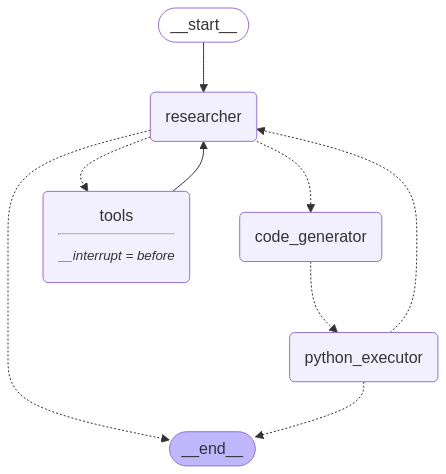

In [ ]:
display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
config = {"configurable": {"thread_id": "107"}}

In [ ]:

thread = config


In [ ]:
initial_input = {
    "messages": [
        HumanMessage(content="""sort the rows in ascending order based on projects column values""")

    ]
}

for event in app.stream(initial_input, thread, stream_mode="values"):
  pass
  #print(event)



snapshot = app.get_state(config)
while snapshot.next:
    if snapshot.next[0] == "tools":
        human_input = input(f"{snapshot.values['messages'][-1].content} ")

        cmd = {
            "messages": [
                HumanMessage(content=human_input)
            ]
        }

        app.update_state(thread, cmd)
        formatted_conversation = ""
        snapshot = app.get_state(config)
        for msg in snapshot.values["messages"]:
          if isinstance(msg, HumanMessage):
              formatted_conversation += f"Human: {msg.content}\n"
          elif isinstance(msg, ToolMessage):
              formatted_conversation += f"Tool: {msg.content}\n"
        # Continue the graph execution
        app.invoke({
            "messages":formatted_conversation
        },thread)
        snapshot = app.get_state(config)
    else:
      print("Error")
      break



print("Process Completed Successfully !!!")

Researcher called
Generator called
Executor called
Researcher called
Process Completed Successfully !!!


In [ ]:
snapshot = app.get_state(config)

In [ ]:
initial_input = {
    "messages": [
        HumanMessage(content="add")
    ]
}
initial_input

{'messages': [HumanMessage(content='add', additional_kwargs={}, response_metadata={})]}

In [ ]:
for event in app.stream(initial_input, thread, stream_mode="values"):
    print(event)

{'messages': [HumanMessage(content='add new headers Name,Skills,Address,Company,Projects', additional_kwargs={}, response_metadata={}, id='ffec9662-bb8f-4734-a5ac-ebcdfc2c884e'), AIMessage(content='Okay, the user wants to add new headers "Skills", "Address", "Company", and "Projects" to the spreadsheet, which currently has headers "Name", "Age", and "City". I need to instruct the next assistant to add these new headers to the spreadsheet.', additional_kwargs={}, response_metadata={}, name='researcher', id='4fc7f0eb-b624-486f-9c4a-696707f7b061'), AIMessage(content='```python\nimport gspread\n\n# Assuming \'sheet\' object is already authenticated and available in the environment.\n\nnew_headers = ["Skills", "Address", "Company", "Projects"]\n\ntry:\n    # Get the existing headers from the first row.\n    existing_headers = sheet.row_values(1)\n\n    # Append the new headers to the existing headers.\n    updated_headers = existing_headers + new_headers\n\n    # Update the first row with t

In [ ]:
snapshot = app.get_state(config)
snapshot.next

('tools',)

In [ ]:
app.update_state(thread, {"messages": [
    HumanMessage(content="add new column with name 'Salary'")
]})

{'configurable': {'thread_id': '103',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0176a8-5ae1-65be-800b-9b0dff7c0ddf'}}

In [ ]:
print(app.get_state(thread).values)

{'messages': [HumanMessage(content='add new headers Name,Skills,Address,Company,Projects', additional_kwargs={}, response_metadata={}, id='ffec9662-bb8f-4734-a5ac-ebcdfc2c884e'), AIMessage(content='Okay, the user wants to add new headers "Skills", "Address", "Company", and "Projects" to the spreadsheet, which currently has headers "Name", "Age", and "City". I need to instruct the next assistant to add these new headers to the spreadsheet.', additional_kwargs={}, response_metadata={}, name='researcher', id='4fc7f0eb-b624-486f-9c4a-696707f7b061'), AIMessage(content='```python\nimport gspread\n\n# Assuming \'sheet\' object is already authenticated and available in the environment.\n\nnew_headers = ["Skills", "Address", "Company", "Projects"]\n\ntry:\n    # Get the existing headers from the first row.\n    existing_headers = sheet.row_values(1)\n\n    # Append the new headers to the existing headers.\n    updated_headers = existing_headers + new_headers\n\n    # Update the first row with t